<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/MNN_fwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the necessary packages**

In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [2]:
from torch import nn
from torch.nn import functional as F

In [3]:
from functorch import jvp
from functools import partial
import time 

In [4]:
import matplotlib.pyplot as plt

# **Loading and preprocessing the data**

In [5]:
#Load the dataset
penguins = tfds.load('penguins', as_supervised=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/processed/1.0.0.incomplete1N88GK/penguins-train.tfrecord*...:   0…

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.


In [6]:
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [8]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [9]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

# **Define MultiLayer Neural Network**

In [10]:
class MNN(nn.Module):
  def __init__(self, input_size, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b):
    super().__init__()

    self.w1 = nn.Parameter(fc1w)
    self.b1 = nn.Parameter(fc1b)
    
    self.w2 = nn.Parameter(fc2w)
    self.b2 = nn.Parameter(fc2b)

    self.w3 = nn.Parameter(fc3w)
    self.b3 = nn.Parameter(fc3b)

  def forward(self, x):
    x = F.relu(x@self.w1 + self.b1)
    x = F.relu(x@self.w2 + self.b2)
    x = x@self.w3 + self.b3
    x = x.reshape(1, -1)
    return torch.softmax(x, 1)

In [11]:
# We check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Initialize the parameters**

In [12]:
# We initialize the parameters randomly with values in [-1, 1] and the model with an input size
fc1w = torch.FloatTensor(4, 64).uniform_(-1, 1)
fc1b = torch.FloatTensor(64).uniform_(-1, 1)
fc2w = torch.FloatTensor(64, 8).uniform_(-1, 1)
fc2b = torch.FloatTensor(8).uniform_(-1, 1)
fc3w = torch.FloatTensor(8, 3).uniform_(-1, 1)
fc3b = torch.FloatTensor(3).uniform_(-1, 1)
mnn = MNN(4, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b).to(device)

In [13]:
# We try our model with the first example
print(mnn(Xtrain[0].to(device)))

tensor([[0.0108, 0.0111, 0.9781]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Calculate predictions

In [14]:
def pred(x, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b):
  ypred=torch.randn((x.shape[0],3))
  for j in range (x.shape[0]):
    xj = x[j]
    xj = F.relu(xj@fc1w + fc1b)
    xj = F.relu(xj@fc2w + fc2b)
    xj = xj@fc3w + fc3b
    xj = xj.reshape(1, -1)
    ypred[j]=torch.softmax(xj, 1)
  return ypred

In [15]:
ypred = pred(Xtrain, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)

# **Define accuracy**

In [16]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [17]:
# Average accuracy at initialization is 33% (random guessing)
accuracy(ytrain.to(device), ypred.to(device))

tensor(0.3600, device='cuda:0')

# **Define Cross-Entropy**

We define one cross_entropy function for each parameter because we will define later partial functions and the parameters need to be in a different order

In [18]:
def cross_entropyWfc1(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, ytrue, x):
  ypred=pred(x, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)
  ypred = ypred.to(device)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [19]:
def cross_entropyBfc1(fc1b, fc1w, fc2w, fc2b, fc3w, fc3b, ytrue, x):
  ypred=pred(x, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)
  ypred = ypred.to(device)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [20]:
def cross_entropyWfc2(fc2w, fc1b, fc1w, fc2b, fc3w, fc3b, ytrue, x):
  ypred=pred(x, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)
  ypred = ypred.to(device)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [21]:
def cross_entropyBfc2(fc2b, fc1b, fc2w, fc1w, fc3w, fc3b, ytrue, x):
  ypred=pred(x, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)
  ypred = ypred.to(device)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [22]:
def cross_entropyWfc3(fc3w, fc1b, fc2w, fc2b, fc1w, fc3b, ytrue, x):
  ypred=pred(x, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)
  ypred = ypred.to(device)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [23]:
def cross_entropyBfc3(fc3b, fc1b, fc2w, fc2b, fc3w, fc1w, ytrue, x):
  ypred=pred(x, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)
  ypred = ypred.to(device)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [24]:
# We check that the output of all the cross_entropy functions is the same
print(cross_entropyWfc1(fc1w.to(device), fc1b.to(device), fc2w.to(device), fc2b.to(device), fc3w.to(device), fc3b.to(device), ytrain.to(device), Xtrain.to(device)))
print(cross_entropyBfc1(fc1b.to(device), fc1w.to(device), fc2w.to(device), fc2b.to(device), fc3w.to(device), fc3b.to(device), ytrain.to(device), Xtrain.to(device)))
print(cross_entropyWfc2(fc2w.to(device), fc1b.to(device), fc1w.to(device), fc2b.to(device), fc3w.to(device), fc3b.to(device), ytrain.to(device), Xtrain.to(device)))
print(cross_entropyBfc2(fc2b.to(device), fc1b.to(device), fc2w.to(device), fc1w.to(device), fc3w.to(device), fc3b.to(device), ytrain.to(device), Xtrain.to(device)))
print(cross_entropyWfc3(fc3w.to(device), fc1b.to(device), fc2w.to(device), fc2b.to(device), fc1w.to(device), fc3b.to(device), ytrain.to(device), Xtrain.to(device)))
print(cross_entropyBfc3(fc3b.to(device), fc1b.to(device), fc2w.to(device), fc2b.to(device), fc3w.to(device), fc1w.to(device), ytrain.to(device), Xtrain.to(device)))

tensor(3.5758, device='cuda:0')
tensor(3.5758, device='cuda:0')
tensor(3.5758, device='cuda:0')
tensor(3.5758, device='cuda:0')
tensor(3.5758, device='cuda:0')
tensor(3.5758, device='cuda:0')


Define error

In [25]:
def error(ytrue, model, x):
  error=0
  for i in range (ytrue.size(0)):
    ypredi = model(x[i].to(device))
    if (ypredi.argmax(1)- ytrue[i])!=0:
      error = error+ 1
  return error

# **Other activation functions**

In [26]:
def beale_function(x):
  return (torch.pow(torch.tensor([1.5])-x[0]+x[0]*x[1],2) + torch.pow(torch.tensor([2.25])-x[0]+x[0]*torch.pow(x[1],2),2)+torch.pow(torch.tensor([2.625])-x[0]+x[0]*torch.pow(x[1],3),2))

In [27]:
def rosenbrock_function(x):
  sum=0
  for p in x.size():
    for i in range (x.size(1)-1):
      sum += (100*torch.pow(x[i+1] - torch.pow(x[i], 2), 2) + torch.pow(x[i]-1, 2))
  return sum

In [28]:
def sphere_function(x):
  sum=0
  for i in range(x.size(0)):
    sum += torch.pow(x[i], 2)
  return sum

# **Train and evaluate the network**

In [29]:
def train_fwd_gradient(x, y):
  x, y = x.to(device), y.to(device)

  losses = [] #Vector with the cross_entropy values of the test set
  accuracies = [] #Vector with the accuracy values of the test set
  errors = [] #Vector with the number of misclassifications of the test set

  l_rate0 = 0.05 #Learning rate used

  # Initialize the parameters
  fc1w = torch.FloatTensor(4, 64).uniform_(-1, 1)
  fc1b = torch.FloatTensor(64).uniform_(-1, 1)
  fc2w = torch.FloatTensor(64, 8).uniform_(-1, 1)
  fc2b = torch.FloatTensor(8).uniform_(-1, 1)
  fc3w = torch.FloatTensor(8, 3).uniform_(-1, 1)
  fc3b = torch.FloatTensor(3).uniform_(-1, 1)

  fc1w, fc1b, fc2w, fc2b, fc3w, fc3b = fc1w.to(device), fc1b.to(device), fc2w.to(device), fc2b.to(device), fc3w.to(device), fc3b.to(device)

  loss = cross_entropyWfc1(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, y, x) # Loss function

  t=0
  it=0
  t0 = time.time()

  while (loss>0.2) :

    # We define the following vectors as a perturbation vector taken as a multivariate random variable (such that their scalar components are independent and have zero mean 
    # and unit variance)

    vfc1w=torch.randn(fc1w.shape).to(device)
    vfc1w=(vfc1w - torch.mean(vfc1w))/torch.std(vfc1w)
    vfc1b=torch.randn(fc1b.shape).to(device)
    vfc1b=(vfc1b - torch.mean(vfc1b))/torch.std(vfc1b)
    vfc2w=torch.randn(fc2w.shape).to(device)
    vfc2w=(vfc2w - torch.mean(vfc2w))/torch.std(vfc2w)
    vfc2b=torch.randn(fc2b.shape).to(device)
    vfc2b=(vfc2b - torch.mean(vfc2b))/torch.std(vfc2b)
    vfc3w=torch.randn(fc3w.shape).to(device)
    vfc3w=(vfc3w - torch.mean(vfc3w))/torch.std(vfc3w)
    vfc3b=torch.randn(fc3b.shape).to(device)
    vfc3b=(vfc3b - torch.mean(vfc3b))/torch.std(vfc3b)

    # We define a partial function for each of the parameters
    fw1 = partial(cross_entropyWfc1, fc1b=fc1b, fc2w=fc2w, fc2b=fc2b, fc3w=fc3w, fc3b=fc3b, ytrue=y, x=x)
    fb1 = partial(cross_entropyBfc1, fc1w=fc1w, fc2w=fc2w, fc2b=fc2b, fc3w=fc3w, fc3b=fc3b, ytrue=y, x=x)
    fw2 = partial(cross_entropyWfc2, fc1b=fc1b, fc1w=fc1w, fc2b=fc2b, fc3w=fc3w, fc3b=fc3b, ytrue=y, x=x)
    fb2 = partial(cross_entropyBfc2, fc1b=fc1b, fc2w=fc2w, fc1w=fc1w, fc3w=fc3w, fc3b=fc3b, ytrue=y, x=x)
    fw3 = partial(cross_entropyWfc3, fc1b=fc1b, fc2w=fc2w, fc2b=fc2b, fc1w=fc1w, fc3b=fc3b, ytrue=y, x=x)
    fb3 = partial(cross_entropyBfc3, fc1b=fc1b, fc2w=fc2w, fc2b=fc2b, fc3w=fc3w, fc1w=fc1w, ytrue=y, x=x)

    # We compute the cross_entropy and the directional derivative of cross_entropy at each parameter in direction v simultaneously and without having to compute
    # ∇cross_entropy in the process
    #This is also known as forward-mode autodiff
    ftw1, dtw1=jvp(fw1,(fc1w, ), (vfc1w, ))
    ftb1, dtb1=jvp(fb1,(fc1b, ), (vfc1b, ))
    ftw2, dtw2=jvp(fw2,(fc2w, ), (vfc2w, ))
    ftb2, dtb2=jvp(fb2,(fc2b, ), (vfc2b, ))
    ftw3, dtw3=jvp(fw3,(fc3w, ), (vfc3w, ))
    ftb3, dtb3=jvp(fb3,(fc3b, ), (vfc3b, ))

    # We multiply the scalar directional derivative ∇cross_entropy(θ)·v with vector v and obtain g(θ), the forward gradient (where θ represents each one of our parameters)
    gtw1 = vfc1w*dtw1
    gtb1 = vfc1b*dtb1
    gtw2 = vfc2w*dtw2
    gtb2 = vfc2b*dtb2
    gtw3 = vfc3w*dtw3
    gtb3 = vfc3b*dtb3

    # Update the parameters
    fc1w -= l_rate0*gtw1
    fc1b -= l_rate0*gtb1
    fc2w -= l_rate0*gtw2
    fc2b -= l_rate0*gtb2
    fc3w -= l_rate0*gtw3
    fc3b -= l_rate0*gtb3

    # We calculate the number of the misclassfications of the test set with the updated model and we add it to the errors vector
    mnn = MNN(4, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)
    ypred = pred(Xtest.to(device), fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)
    errors.append(error(ytest, mnn, Xtest))

    # We calculate the cross_entropy of the test set with the updated model and we add it to the losses vector
    losses.append(cross_entropyWfc1(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, ytest.to(device), Xtest.to(device)).cpu())

    # We calculate the accuracy of the test set with the updated model and we add it to the accuracies vector
    accuracies.append(accuracy(ytest, ypred).item())

    # We calculate the loss
    loss = cross_entropyWfc1(fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, y, x)

    # We add the execution time of the iteration
    t1=time.time()
    t+=t1-t0
    t0=t1
    it+=1

    print('Time', t, 'loss', loss)

  print('Final execution time', t)  
  print('Number of iterations', it)
  print('Mean execution time of an iteration', t/it)

  return fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, losses, accuracies, errors

In [30]:
fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, losses, accuracies, errors = train_fwd_gradient(Xtrain, ytrain)

Time 1.2583489418029785 loss tensor(2.0876, device='cuda:0')
Time 2.3794305324554443 loss tensor(1.6410, device='cuda:0')
Time 3.559058427810669 loss tensor(1.5127, device='cuda:0')
Time 4.668467283248901 loss tensor(1.4471, device='cuda:0')
Time 5.767117023468018 loss tensor(0.9842, device='cuda:0')
Time 6.886388301849365 loss tensor(1.2296, device='cuda:0')
Time 8.002243280410767 loss tensor(1.2703, device='cuda:0')
Time 9.49682331085205 loss tensor(0.7300, device='cuda:0')
Time 10.883466243743896 loss tensor(0.6051, device='cuda:0')
Time 12.001219272613525 loss tensor(0.5562, device='cuda:0')
Time 13.122686862945557 loss tensor(0.5319, device='cuda:0')
Time 14.21532416343689 loss tensor(0.4661, device='cuda:0')
Time 15.309510946273804 loss tensor(0.4499, device='cuda:0')
Time 16.432024717330933 loss tensor(0.4396, device='cuda:0')
Time 17.53767228126526 loss tensor(0.4070, device='cuda:0')
Time 18.652554988861084 loss tensor(0.3831, device='cuda:0')
Time 19.78374934196472 loss tenso

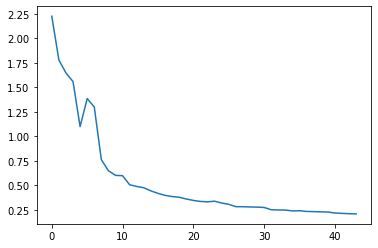

In [31]:
plt.plot(losses)

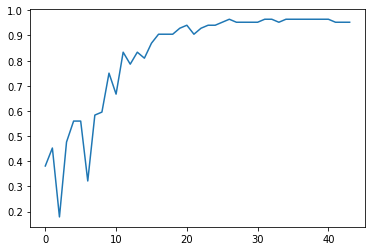

In [32]:
plt.plot(accuracies)

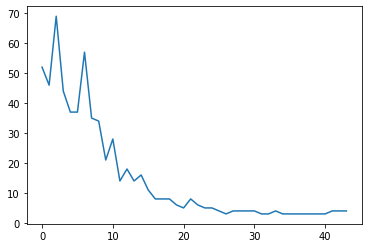

In [33]:
plt.plot(errors)